# EP2 - Modelando o SARS-CoV-2

Hello, little fellows.

In [133]:
import math                          # exp(), ...
import matplotlib.pyplot as pyplot   # plot(), ...
import numpy                         # ones(), ...

# Animação
from matplotlib import animation, rc
from IPython.display import HTML
import random
import requests
import os
from io import BytesIO

Neste EP você vai simular o modelo dinâmico do COVID-19 resolvendo numericamente, por
Euler, a eq. 4 para algumas situações diferentes ligadas aos parâmetros $\alpha, \lambda,$ A e $t_0$.

$\frac{dN}{dt} = \alpha \bigg(1 - \frac{N}{\eta t^2} \bigg)N - \bigg(\frac{2\lambda t^2 - 1}{t} - \frac{\lambda (t_0)^2}{t} e^{-\lambda (t-t_0)^2}\bigg)N$

sendo $\alpha > 0$ o fator de crescimento, $t_0$ o tempo inicial que depende de medidas de restrição, $\lambda = \sigma^{-1}$ e $\eta = 2A/t_0$, onde A é um parâmetro que depende do vírus e das medidas de restrição.

1. Assumindo que estamos numa ilha isolada, simule a evolução de N para um conjunto {$\alpha, \lambda$, A, $t_0$}. Nesse caso, o vetor de estados é unidimensional v(t) = \[N\](t). Faça um gráfico bonito para mostrar a evolução de v em relação a t, i.e. v(t). Faça também uma simulação dinâmica usando os recursos explicados em aula.

Dado o enunciado, a função que nos interessa recebe como parâmetros {$\alpha, \lambda, t_0, A$}. Sua evolução deve ser modelada a partir do método de Euler, por meio do qual se realiza uma aproximação da equação diferencial a partir de diferenças finitas:

$$\frac{dN}{dt} =  \frac{N_{t+1} - N_{t}}{dt} \rightarrow N_{t+1} = N_t + \bigg[\alpha \bigg(1 - \frac{N}{\eta t^2} \bigg)N - \bigg(\frac{2\lambda t^2 - 1}{t} - \frac{\lambda (t_0)^2}{t} e^{-\lambda (t-t_0)^2}\bigg)N \bigg]dt $$

seja $N = N_t$, temos

$$N_{t+1} = N_t + \bigg[\alpha \bigg(1 - \frac{N_t}{\eta t^2} \bigg)N_t - \bigg(\frac{2\lambda t^2 - 1}{t} - \frac{\lambda (t_0)^2}{t} e^{-\lambda (t-t_0)^2}\bigg)N_t \bigg]dt \\ $$

que é o número de pessoas infectadas para um tempo $t$.

## Método de Euler

In [134]:
# N é o número de pessoas infectadas num certo tempo t

def nextN(N_0, dt, alfa, lamb, t0, A, t):
    eta = (2*A)/t0
    #print(eta)
    
    N  = alfa*(1-N_0/(eta*t**2))
    aux = ((2*lamb*t**2 -1)-(lamb*t0**2)*(math.exp(-lamb*(t-t0)**2)))/t
    #print(aux)
    N -= aux
    N *= N_0
    
    # Euler
    N *= dt
    N += N_0
    
    return N

## Simulação 

In [135]:
# Retorna o vetor de estados

def sim():
    # Alguns dos dados abaixo foram retirados do 
    # documento do Sonino para o caso da Itália (p. 12)
    # https://arxiv.org/pdf/2003.13540v5.pdf
    # A maioria é aleatória tho
    
    N_0 = 50            # 165155 - número de casos em t0
    dt = 1              # passo = 1 dia
    t0 = 10             # 70.6 - parâmetro relativo ao pico da curva?
    lamb = 0.001        # 0.0014 - para uma simulação decente, tive que usar na ordem de 10^{-3}
    alfa = 2*t0*lamb    # 0.2 - do pdf, alfa = 2t0*lamb
    A = 100             # 302.5 
    
    t = 1
    N = N_0
    v = []
    t_f = 100
    
    while(t < t_f and N >= 1):
        v.append(int(N))
        t += dt
        N = nextN(N, dt, alfa, lamb, t0, A, t)
        
    #print(v)
    return v

### Simulação em Gráfico:

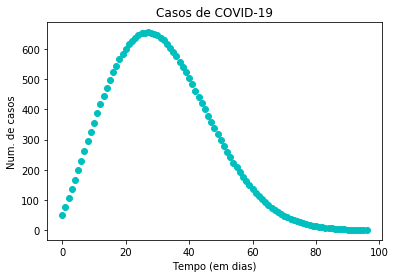

In [136]:
def simPlot(v):
    pyplot.figure()
    pyplot.plot(v,linestyle='',marker='o',color='c')
    pyplot.title('Casos de COVID-19')
    pyplot.ylabel('Num. de casos')
    pyplot.xlabel('Tempo (em dias)')
    pyplot.show()    

simPlot(sim())

### Simulação Dinâmica:

In [143]:
def init_animate():
    line.set_data([], [])
    return (line,)

def animate(i):
    ind0 = i%len(yAnim)
    ind1 = (i+1)%len(yAnim)
    ind1 = ind0
    line.set_data([xAnim[ind0], xAnim[ind1]] , [yAnim[ind0], yAnim[ind1]])
    #ind = i%len(yAnim)
    #line.set_data(xAnim[ind], yAnim[ind]
    return (line,)

def createAnimPlot(title):
    figAnim, axAnim = pyplot.subplots(1, 1)
    axAnim = pyplot.axes(xlim=(-5, 100), ylim=(-20, 700))
    
    pyplot.title(title)
    
    line, = axAnim.plot([], [], 'r-*', lw=5)
    frames=len(yAnim)-1
    
    return(figAnim, axAnim, frames, line)

t = 1
tempo = []
v = sim()
t_f = len(v)
#print(t_f)
#t_f = 10
#v = v[0:10]

while(t <= t_f):
    tempo.append(t)
    t += 1

#print(v)
#print(tempo)

yAnim = v
xAnim = tempo
figAnim, axAnim, frames, line = createAnimPlot('Casos de COVID-19 ao longo do tempo')
anim = animation.FuncAnimation(figAnim, animate, init_func=init_animate, frames=frames, interval=50, blit=True)
rc('animation', html='jshtml')
pyplot.ylabel('Num. de casos')
pyplot.xlabel('Tempo (em dias)')
pyplot.close()

anim